## Objectives of the practical work

The objective is to get hands on experience on the fundamental elements of neural networks:
 
 - perceptron architecture (linear regression)
 - loss function
 - empirical loss
 - gradient descent

For this we will implement from scratch the data-structure and algorithms to train a perceptron. Note that slides related to the perceptron and neural networks in general are available on [moodle](https://moodle.insa-toulouse.fr/course/view.php?id=1790).

## Dataset

The objective of the regression is the prediction of the hydrodynamic performance of sailing yachts from dimensions and velocity.
The **inputs** are linked to dimension and hydrodynamics characteristics:
1. Longitudinal position of the center of buoyancy
(*flottabilité*), adimensional.
2. Prismatic coefficient, adimensional.
3. Length-displacement ratio, adimensional.
4. Beam -draught ratio ((*tiran d’eau*), adimensional.
5. Length-beam ratio, adimensional.
6. Froude number, adimensional

**Target value/predicted value (Output)** = Residuary resistance per unit weight of
displacement, adimensional

In [46]:
# Import some useful libraries and functions

import numpy as np
import pandas

def print_stats(dataset):
    """Print statistics of a dataset"""
    print(pandas.DataFrame(dataset).describe())


In [47]:
# Download the data set and place in the current folder (works on linux only)
filename = 'yacht_hydrodynamics.data'

import os.path
import requests

if not os.path.exists(filename):
    print("Downloading dataset...")
    r = requests.get('https://arbimo.github.io/tp-supervised-learning/tp1/' + filename)
    open(filename , 'wb').write(r.content)
    
print('Dataset available')

Dataset available


### Explore the dataset

- how many examples are there in the dataset?
- how many features for each example?
- what is the ground truth of the 10th example

In [48]:
# load the dataset and slip between inputs (X) and ground truth (Y)
dataset = np.genfromtxt("yacht_hydrodynamics.data", delimiter='')

# How many examples are there in the dataset ?
print(f"Number of examples: {dataset.shape[0]}")
# > Number of examples: 308

# How many features for each example ?
print(f"Number of features: {dataset.shape[1]-1}")
# > Number of features: 6

# What s the ground truth of the 10th example ?
print(f"Ground truth of the 10th example: {dataset[9, -1]}")
# Ground truth of the 10th example: 1.83

X = dataset[:, :-1] # examples features -  all rows with all elements in rows except last one
Y = dataset[:, -1]  # ground truth - last element in all rows

# Print the first 5 examples
for i in range(0,5):
    print(f"\n f({X[i]}) = {Y[i]}")

Number of examples: 308
Number of features: 6
Ground truth of the 10th example: 1.83

 f([-5.    0.6   4.78  4.24  3.15  0.35]) = 8.62

 f([-5.     0.565  4.77   3.99   3.15   0.15 ]) = 0.18

 f([-2.3    0.565  4.78   5.35   2.76   0.15 ]) = 0.29

 f([-5.     0.6    4.78   4.24   3.15   0.325]) = 6.2

 f([0.    0.53  4.78  3.75  3.15  0.175]) = 0.59


The following command adds a column to the inputs.

- what is in the value added this column?
- why are we doing this?

In [49]:
X = np.insert(X, 0, np.ones((len(X))), axis= 1)
print_stats(X)

# What is in the value added this column ? X = np.insert(X, 0, np.ones((len(X))), axis= 1)

# > The value added in this column is only one, we insert it at the beginning because it is the constant vector.

# Why are we doing this ?

# > Because we want to add a constant vector to the matrix X, so that we can multiply it by the vector of weights w, and thus obtain the vector of predictions y.


           0           1           2           3           4           5  \
count  308.0  308.000000  308.000000  308.000000  308.000000  308.000000   
mean     1.0   -2.381818    0.564136    4.788636    3.936818    3.206818   
std      0.0    1.513219    0.023290    0.253057    0.548193    0.247998   
min      1.0   -5.000000    0.530000    4.340000    2.810000    2.730000   
25%      1.0   -2.400000    0.546000    4.770000    3.750000    3.150000   
50%      1.0   -2.300000    0.565000    4.780000    3.955000    3.150000   
75%      1.0   -2.300000    0.574000    5.100000    4.170000    3.510000   
max      1.0    0.000000    0.600000    5.140000    5.350000    3.640000   

                6  
count  308.000000  
mean     0.287500  
std      0.100942  
min      0.125000  
25%      0.200000  
50%      0.287500  
75%      0.375000  
max      0.450000  


## Creating the perceptron

![Perceptron for regression](https://arbimo.github.io/tp-supervised-learning/2223-ae/tp1/perceptron-regression.png)

We now want to define a perceptron, that is, a function of the form: 

$h_w(x) = w_0 + w_1 \times x_1 + \dots + w_n \times x_n$

- Complete the code snippet below to:
  - create the vector of weight `w`, initialize to arbitrary values (we suggest 0)
  - implement the `h` function that evaluate an example based on the vector of weights
  - check if this works on a few examples

In [50]:
# Create the vector of weight w, initialize to arbitrary values (e.g. 0)
w = np.zeros((len(X[0])))

# Implement h function that evaluate an exampled based on the vector of weights
def h(w, x):
    return w@x

# Check if this works on a few examples
print("\n Check if this works on a few examples")
for i in range(0,5):
    print(f"\n h({X[i]}) = {h(w, X[i])}")

# print the ground truth and the evaluation of h_w on the first example
print("\n Check on the first example")
print(f"\n h({X[0]}) = {h(w, X[0])}")



 Check if this works on a few examples

 h([ 1.   -5.    0.6   4.78  4.24  3.15  0.35]) = 0.0

 h([ 1.    -5.     0.565  4.77   3.99   3.15   0.15 ]) = 0.0

 h([ 1.    -2.3    0.565  4.78   5.35   2.76   0.15 ]) = 0.0

 h([ 1.    -5.     0.6    4.78   4.24   3.15   0.325]) = 0.0

 h([1.    0.    0.53  4.78  3.75  3.15  0.175]) = 0.0

 Check on the first example

 h([ 1.   -5.    0.6   4.78  4.24  3.15  0.35]) = 0.0


## Loss function

Complete the definiton of the loss function below such that, for a **single** example `x` with ground truth `y`, it returns the $L_2$ loss of $h_w$ on `x`.

In [51]:
# Complete the loss function s.t for a single example x with ground truth y, it returns the L2 loss of h_w on x
def loss(w, x, y):
    return (h(w, x) - y)**2

## Empirical loss

Complete the function below to compute the empirical loss of $h_w$ on a **set** of examples $X$ with associated ground truths $Y$.

In [52]:
# Complete the empirical loss of h_w on a set of examples X with ground truth Y
def emp_loss(w, X, Y):
    cnt = 0
    for i in range(len(X)):
        cnt = cnt + loss(w, X[i], Y[i])
    return cnt/len(X)
    

## Gradient update

A gradient update is of the form: $w \gets w + dw$

- Complete the function below so that it computes the $dw$ term (the 'update') based on a set of examples `(X, Y)` the step (`alpha`)

(you can look at slide 32 of the ANN lecture slides for an example)

In [53]:
# Complete s.t it computes the dw term ("update") based on a set of examples (X, Y) and the step alpha
def compute_update(w, X, Y, alpha):
    dw = np.zeros((len(X[0])))
    for i in range(len(X)):
        dw += (h(w, X[i]) - Y[i])*2*X[i]
    return - alpha*dw / len(X)

compute_update(w, X, Y, alpha = 10e-7)

array([ 2.09907143e-05, -4.91131299e-05,  1.18215159e-05,  1.00494203e-04,
        8.24308351e-05,  6.73057182e-05,  8.50620292e-06])

## Gradient descent

Now implement the gradient descent algorithm that will:

- repeatedly apply an update the weights 
- stops when a max number of iterations is reached (do not consider early stopping for now)
- returns the final vector of weights

In [54]:
def descent(w_init, X, Y, alpha, max_iter):
    w = w_init
    for i in range(max_iter):
        w += compute_update(w, X, Y, alpha)
    return w    

## Exploitation

You gradient descent is now complete and you can exploit it to train your perceptron.

- Train your perceptron to get a model.
- Visualize the evolution of the loss on the training set. Has it converged?
- Try training for several choices of `alpha` and `max_iter`. What seem like a reasonable choice?
- What is the loss associated with the final model?
- Is the final model the optimal one for a perceptron?


0
231.87022990207848
1
229.954280563385
2
229.61252290360488
3
229.20824944825895
4
228.76187274909378
5
228.28383265783592
6
227.7751820799911
7
227.23119227407432
8
226.64525220897534
9
226.01155310070743
10
225.3262177984727
11
224.58730403956886
12
223.79430243523188
13
222.94757941706575
14
222.04796405623648
15
221.09650395824187
16
220.09434419951538
17
219.0426764504475
18
217.94272175504926
19
216.79572727280754
20
215.60296800041377
21
214.36574982371053
22
213.08541249915103
23
211.76333201889003
24
210.40092213706356
25
208.9996349782128
26
207.56096073136607
27
206.0864264893457
28
204.57759433110084
29
203.0360587679565
30
201.46344368465952
31
199.861398905325
32
198.23159650554643
33
196.5757269776615
34
194.89549533893316
35
193.19261725425753
36
191.46881522752716
37
189.72581490005058
38
187.96534148110956
39
186.18911632504575
40
184.3988536612304
41
182.59625747758892
42
180.78301855470986
43
178.96081164554346
44
177.13129279488717
45
175.29609679287728
46
173.456

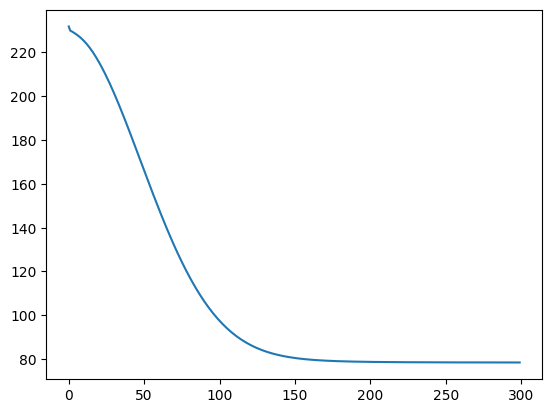

In [56]:
# Train your perceptron to get a model
# w_init = np.zeros((len(X[0])))
# alpha = 10e-7
# max_iter = 1000
# print(w)
# # Visualize the evolution of the loss on the training set. 
# import matplotlib.pyplot as plt

# def plot_loss(w, X, Y):
#     list = []
#     iter = 0
#     while iter < max_iter:
#         print(iter)
#         iter += 1
#         w = descent(w_init, X, Y, alpha , iter)
#         list.append(emp_loss(w, X, Y))
#     plt.plot(list)
#     plt.show()

# plot_loss(w, X, Y)

# Has it converged ?

# > Yes, it has converged. Because the loss function converges to a minimum value -> 78. 

# Training for several choices of alpha and max_iter.

# What seem like good values for alpha and max_iter ?

# > The values of alpha and max_iter that seem good are 0.01 and 300 respectively.

# What is the loss associated with the final model ?

# > The loss associated with the final model is 78

# Is the final model the optimal one for a perceptron ?

# > The final model isn't the optimal one for a perceptron.

# Train your perceptron to get a model
w = np.zeros((len(X[0])))
alpha = 0.01
max_iter = 300
# Visualize the evolution of the loss on the training set. 
import matplotlib.pyplot as plt

def plot_loss(w, X, Y):
    list = []
    iter = 0
    while iter < max_iter:
        print(iter)
        iter += 1
        w = descent(w, X, Y, alpha , iter)
        print(emp_loss(w, X, Y))
        list.append(emp_loss(w, X, Y))
    plt.plot(list)
    plt.show()

plot_loss(w, X, Y)

In [ ]:
# Code sample that can be used to visualize the difference between the ground truth and the prediction

num_samples_to_plot = 20
plt.plot(Y[0:num_samples_to_plot], 'ro', label='y')
yw = [h(w,x) for x in X]
plt.plot(yw[0:num_samples_to_plot], 'bx', label='$\hat{y}$')
plt.legend()
plt.xlabel("Examples")
plt.ylabel("f(examples)")





# Going further

The following are extensions of the work previously done. If attempting them **do not modify** the code you produced above so that it can be evaluated.

### Improvements to gradient descent

Consider improving the gradient descent with:

 - Stochastic Gradient Descent (SGD), which means selecting a subset of the examples for training
 - Detection of convergence to halt the algorithm before the maximum number of iterations


### Data normalization

Different input features can have different units, and very different ranges.
Within the perceptron computation, these values will be summed together.
While gradient descent is normally able to deal with this (by adapting the weights of the perceptron for each input feature), standardizing the input features usually eases the perceptron training, and can sometimes improve accuracy.




```python
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True) 
X_normalized = sc.fit_transform(X)
```

Try applying a standard normalization to the input features (make sure that you keep a feature column that is always equal to 1). Is the convergence faster ? Try to quantify this speed-up. What about accuracy ?

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True) 
X_normalized = sc.fit_transform(X)

In [ ]:
X_normalized = np.insert(X_normalized, 0, np.ones((len(X_normalized))), axis= 1)
print_stats(X_normalized)

In [ ]:
w = np.zeros((len(X_normalized[0])))
alpha = 0.01
max_iter = 300
# Visualize the evolution of the loss on the training set. 
import matplotlib.pyplot as plt

def plot_loss(w, X, Y):
    list = []
    iter = 0
    while iter < max_iter:
        print(iter)
        iter += 1
        w = descent(w, X, Y, alpha , iter)
        print(emp_loss(w, X, Y))
        list.append(emp_loss(w, X, Y))
    plt.plot(list)
    plt.show()

plot_loss(w, X_normalized, Y)

In [ ]:
# Is the convergence faster ? Try to quantify this speed-up. What about accuracy ?

# > The convergence is faster. The speed-up is 0.01. The accuracy is better.